# **Consumer Analytical Profile Analysis (LDP) for 1 Week Interactions**

In [1]:
%run bi_feature_eng_utilities.ipynb 
!pip install pyarrow
!pip install dask
#Clean up previous tables
!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions/tables

    100% |████████████████████████████████| 122kB 58.2MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 2.4MB/s ta 0:00:01
    100% |████████████████████████████████| 5.6MB 8.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/16/8a/1fc3dba0c4923c2a76e1ff0d52b305c44606da63f718d14d3231e21c51b0/s3transfer-0.2.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 235kB 59.5MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 61.3MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/36/fa/08e9e6e0e3cbd1d362c3bbee8d01d0aedb2155c4ac112b19ef3cae8eed8d/docutils-0.14-py3-none-any.whl
  Running setup.py bdist_wheel for move-dl-common-api ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/57/77/47/62e0d2c17e9e2a7818ed7bab55e570ecd03f4ec8b9f33121f1
S

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing

# Random Sample input data if too large this number should be presented as integer ]0,100]
sample_rate_percentage = 100

s3 = s3fs.S3FileSystem()

In [3]:
# It runs k-mean for up to up_to_max_cluster_number ()
def run_k_mean(df, up_to_max_cluster_number, title):
    distortions = []
    for i in range(1, up_to_max_cluster_number):
        print('iteration {}'.format(i))
        km = KMeans(
            n_clusters=i, 
            init='random',
            n_init=10, 
            max_iter=300,
            tol=1e-04, 
            random_state=0,
            n_jobs=multiprocessing.cpu_count()-2 
        )
        km.fit(df)
        distortions.append(km.inertia_)

    df_labels = km.predict(df)
    df_centroids = km.cluster_centers_

    # plot number of clusters against distoration to find optimal number of clusters for 
    plt.plot(range(1, up_to_max_cluster_number), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(title)
    plt.show()

    return (df_labels, df_centroids, distortions )

In [4]:
user_interactions_db_handler= FeatureEngineeringUtilities(db_name= 'buyer_intent_user_interactions', 
                                                          db_path_on_s3 = 's3://datascience-workspace-dev/buyer-intent/user_interactions', 
                                                          logger_name = 'buyer_intent')

2019-08-02 18:00:56.214 INFO athena_util.py.111 - Read config from default schema
2019-08-02 18:00:56.215 INFO athena_util.py.114 - Schema fetched from default config file:


In [5]:
user_interactions_db_handler.drop_table('biui_sampled_{}_consumer_analytical_profile_summary_t007'.format(
                                                                    str(int((100/sample_rate_percentage)*100))))
user_interactions_db_handler.random_sample_based_on_string_attr(from_table_name = 'biui_consumer_analytical_profile_summary_t007',
                                                                to_table_name = 'biui_sampled_{}_consumer_analytical_profile_summary_t007'.format(
                                                                    str(int((100/sample_rate_percentage)*100))),
                                                                sample_rate = int(100/sample_rate_percentage),
                                                                string_atr = 'member_id',
                                                                extr_loc_by_table_name = True)

2019-08-02 18:01:00.370 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-02 18:01:00.484 INFO athena_util.py.462 - 2019-08-02 18:01:00.484715
2019-08-02 18:01:02.058 INFO athena_util.py.464 - 2019-08-02 18:01:02.058664
2019-08-02 18:01:02.262 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-02 18:01:02.465 INFO athena_util.py.462 - 2019-08-02 18:01:02.465040
2019-08-02 18:01:18.718 INFO athena_util.py.464 - 2019-08-02 18:01:18.718801


0

In [6]:
res = user_interactions_db_handler.get_table_size('biui_sampled_{}_consumer_analytical_profile_summary_t007'.format(
    str(int((100/sample_rate_percentage)*100))))
print(res)

2019-08-02 18:01:18.786 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-02 18:01:18.845 INFO athena_util.py.462 - 2019-08-02 18:01:18.845466
2019-08-02 18:01:20.443 INFO athena_util.py.464 - 2019-08-02 18:01:20.443051
12880236


In [7]:
s3_data_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/{}'.format(
    'biui_sampled_{}_consumer_analytical_profile_summary_t007'.format(str(int((100/sample_rate_percentage)*100))))
print(s3_data_path)

s3://datascience-workspace-dev/buyer-intent/user_interactions/tables/biui_sampled_100_consumer_analytical_profile_summary_t007


In [8]:
df = pq.ParquetDataset(s3_data_path, filesystem=s3).read_pandas().to_pandas()

## **Basic Statistical Analysis : Dimension Reduction**

In [10]:
#Clean up non-numeric variables for k-mean
df = df.drop(columns=['snapshot_date_mst_yyyymmdd','member_id','most_recent_ldp_visit_date', 'ldp_dominant_zip'])

In [11]:
#Filter based on different segments
unique_segments = df['ldp_dominant_segment'].unique()
print(unique_segments)

['for sale' 'no_segment' 'for rent' 'not for sale']


In [12]:
unique_number_of_segments = len(unique_segments)
print(unique_number_of_segments)

4


In [13]:
#Filter based on different segments
unique_segments = df['ldp_dominant_segment'].unique()
print(unique_segments)

['for sale' 'no_segment' 'for rent' 'not for sale']


### Now Partition Based on different Segments like : ['for sale' 'not for sale' 'no_segment' 'for rent']

In [14]:
df_for_sale = df.loc[df['ldp_dominant_segment'] == 'for sale']
df_no_segment = df.loc[df['ldp_dominant_segment'] == 'no_segment']
df_not_for_sale = df.loc[df['ldp_dominant_segment'] == 'not for sale']
df_for_rent = df.loc[df['ldp_dominant_segment'] == 'for rent']

In [16]:
#Get correlation matrix for possible dimension reduction
corr_df_for_sale = df_for_sale.corr()
corr_df_for_sale.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.108012,0.298538,0.0166892,0.762409,-0.0560932,-0.0596268,0.446655,0.882503,0.885838,0.882503,0.882503,0.885838,0.885838
median_ldp_page_views,0.108012,1,0.78466,0.359807,0.110355,0.394611,0.23478,0.154231,0.00688453,0.00749831,0.00688453,0.00688453,0.00749831,0.00749831
average_ldp_page_views,0.298538,0.78466,1,0.378192,0.304323,0.267267,0.186517,0.360882,0.128855,0.130592,0.128855,0.128855,0.130592,0.130592
average_ldp_dwell_time_seconds,0.0166892,0.359807,0.378192,1,0.211679,0.841124,0.736636,0.464142,-0.0372746,-0.0366784,-0.0372746,-0.0372746,-0.0366784,-0.0366784
total_ldp_dwell_time_seconds,0.762409,0.110355,0.304323,0.211679,1,0.0237493,-0.0296667,0.735763,0.647526,0.653533,0.647526,0.647526,0.653533,0.653533
median_ldp_dwell_time_seconds,-0.0560932,0.394611,0.267267,0.841124,0.0237493,1,0.702114,0.170431,-0.0878485,-0.0879851,-0.0878485,-0.0878485,-0.0879851,-0.0879851
minimum_ldp_dwell_time_seconds,-0.0596268,0.23478,0.186517,0.736636,-0.0296667,0.702114,1,0.0730256,-0.0802663,-0.080516,-0.0802663,-0.0802663,-0.080516,-0.080516
maximum_ldp_dwell_time_seconds,0.446655,0.154231,0.360882,0.464142,0.735763,0.170431,0.0730256,1,0.364539,0.367616,0.364539,0.364539,0.367616,0.367616
total_distinct_listings_viewed,0.882503,0.00688453,0.128855,-0.0372746,0.647526,-0.0878485,-0.0802663,0.364539,1,0.998949,1,1,0.998949,0.998949
total_listings_viewed,0.885838,0.00749831,0.130592,-0.0366784,0.653533,-0.0879851,-0.080516,0.367616,0.998949,1,0.998949,0.998949,1,1


In [18]:
corr_df_no_segment = df_no_segment.corr()
corr_df_no_segment.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.0260956,0.0811125,-0.00806241,0.749834,-0.0461752,-0.0484832,0.383143,0.897548,0.89932,0.897548,0.897548,0.89932,0.89932
median_ldp_page_views,0.0260956,1,0.973649,0.392545,0.0359405,0.382716,0.397061,0.165879,-0.0614916,-0.0616944,-0.0614916,-0.0614916,-0.0616944,-0.0616944
average_ldp_page_views,0.0811125,0.973649,1,0.392246,0.0920871,0.352587,0.394517,0.216488,-0.0172421,-0.017436,-0.0172421,-0.0172421,-0.017436,-0.017436
average_ldp_dwell_time_seconds,-0.00806241,0.392545,0.392246,1,0.2227,0.942911,0.914836,0.590452,-0.0524239,-0.0521306,-0.0524239,-0.0524239,-0.0521306,-0.0521306
total_ldp_dwell_time_seconds,0.749834,0.0359405,0.0920871,0.2227,1,0.13439,0.0865599,0.71592,0.711219,0.712881,0.711219,0.711219,0.712881,0.712881
median_ldp_dwell_time_seconds,-0.0461752,0.382716,0.352587,0.942911,0.13439,1,0.836895,0.472458,-0.0869355,-0.0867816,-0.0869355,-0.0869355,-0.0867816,-0.0867816
minimum_ldp_dwell_time_seconds,-0.0484832,0.397061,0.394517,0.914836,0.0865599,0.836895,1,0.366842,-0.0876111,-0.0868736,-0.0876111,-0.0876111,-0.0868736,-0.0868736
maximum_ldp_dwell_time_seconds,0.383143,0.165879,0.216488,0.590452,0.71592,0.472458,0.366842,1,0.352912,0.35255,0.352912,0.352912,0.35255,0.35255
total_distinct_listings_viewed,0.897548,-0.0614916,-0.0172421,-0.0524239,0.711219,-0.0869355,-0.0876111,0.352912,1,0.99895,1,1,0.99895,0.99895
total_listings_viewed,0.89932,-0.0616944,-0.017436,-0.0521306,0.712881,-0.0867816,-0.0868736,0.35255,0.99895,1,0.99895,0.99895,1,1


In [20]:
corr_df_not_for_sale = df_not_for_sale.corr()
corr_df_not_for_sale.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.209061,0.316302,0.0347615,0.577591,0.0105585,-0.0397981,0.286116,0.829906,0.830559,0.829906,0.829906,0.830559,0.830559
median_ldp_page_views,0.209061,1,0.887607,0.261314,0.161937,0.308383,0.188573,0.240458,-0.0364827,-0.036233,-0.0364827,-0.0364827,-0.036233,-0.036233
average_ldp_page_views,0.316302,0.887607,1,0.310665,0.229569,0.312704,0.239935,0.308547,-0.00614278,-0.00607636,-0.00614278,-0.00614278,-0.00607636,-0.00607636
average_ldp_dwell_time_seconds,0.0347615,0.261314,0.310665,1,0.556264,0.956552,0.9342,0.824223,-0.0503966,-0.0500019,-0.0503966,-0.0503966,-0.0500019,-0.0500019
total_ldp_dwell_time_seconds,0.577591,0.161937,0.229569,0.556264,1,0.49706,0.375392,0.835684,0.499663,0.502115,0.499663,0.499663,0.502115,0.502115
median_ldp_dwell_time_seconds,0.0105585,0.308383,0.312704,0.956552,0.49706,1,0.8659,0.756986,-0.0731963,-0.0727024,-0.0731963,-0.0731963,-0.0727024,-0.0727024
minimum_ldp_dwell_time_seconds,-0.0397981,0.188573,0.239935,0.9342,0.375392,0.8659,1,0.631599,-0.0934136,-0.0935396,-0.0934136,-0.0934136,-0.0935396,-0.0935396
maximum_ldp_dwell_time_seconds,0.286116,0.240458,0.308547,0.824223,0.835684,0.756986,0.631599,1,0.180799,0.181293,0.180799,0.180799,0.181293,0.181293
total_distinct_listings_viewed,0.829906,-0.0364827,-0.00614278,-0.0503966,0.499663,-0.0731963,-0.0934136,0.180799,1,0.998532,1,1,0.998532,0.998532
total_listings_viewed,0.830559,-0.036233,-0.00607636,-0.0500019,0.502115,-0.0727024,-0.0935396,0.181293,0.998532,1,0.998532,0.998532,1,1


In [22]:
corr_df_for_rent = df_for_rent.corr()
corr_df_for_rent.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.166888,0.349372,0.0190626,0.745157,-0.0627016,-0.0706555,0.43328,0.888786,0.88993,0.888786,0.888786,0.88993,0.88993
median_ldp_page_views,0.166888,1,0.856752,0.271363,0.122006,0.273533,0.157469,0.157477,0.0151779,0.0153103,0.0151779,0.0151779,0.0153103,0.0153103
average_ldp_page_views,0.349372,0.856752,1,0.298329,0.307526,0.186722,0.116713,0.337864,0.15334,0.153224,0.15334,0.15334,0.153224,0.153224
average_ldp_dwell_time_seconds,0.0190626,0.271363,0.298329,1,0.263652,0.834499,0.722465,0.534672,-0.0325678,-0.0320483,-0.0325678,-0.0325678,-0.0320483,-0.0320483
total_ldp_dwell_time_seconds,0.745157,0.122006,0.307526,0.263652,1,0.052521,-0.0219982,0.749104,0.681904,0.683524,0.681904,0.681904,0.683524,0.683524
median_ldp_dwell_time_seconds,-0.0627016,0.273533,0.186722,0.834499,0.052521,1,0.696565,0.214849,-0.0953519,-0.0947827,-0.0953519,-0.0953519,-0.0947827,-0.0947827
minimum_ldp_dwell_time_seconds,-0.0706555,0.157469,0.116713,0.722465,-0.0219982,0.696565,1,0.0931025,-0.0921327,-0.0916256,-0.0921327,-0.0921327,-0.0916256,-0.0916256
maximum_ldp_dwell_time_seconds,0.43328,0.157477,0.337864,0.534672,0.749104,0.214849,0.0931025,1,0.379932,0.37988,0.379932,0.379932,0.37988,0.37988
total_distinct_listings_viewed,0.888786,0.0151779,0.15334,-0.0325678,0.681904,-0.0953519,-0.0921327,0.379932,1,0.998869,1,1,0.998869,0.998869
total_listings_viewed,0.88993,0.0153103,0.153224,-0.0320483,0.683524,-0.0947827,-0.0916256,0.37988,0.998869,1,0.998869,0.998869,1,1


## **Summary of Correlated Parameters** :

About 12 Million members:

| VERY HIGHLY Correlated Features( >.99) | HIGHLY Correleated Features (~0.9) | 
|------|------|
|   total_distinct_listings_viewed  | total_ldp_dwell_time_seconds|
|   median_distinct_listings_viewed  | total_distinct_listings_viewed|
|   average_distinct_listings_viewed  | median_distinct_listings_viewed|
|   median_listings_viewed  | average_distinct_listings_viewed |
|   average_total_listings_viewed  | median_listings_viewed|
||average_total_listings_viewed|

## **Conclusions**:
* For HIGHLY Correlated we could use only total_ldp_page_views
* **Important 8 Variables out of 14 variables** :  
    1. *total_ldp_page_views*,
    2. *total_ldp_dwell_time_seconds*, 
    3. median_ldp_page_views, 
    4. average_ldp_page_views, 
    5. median_ldp_dwell_time_seconds, 
    6. average_ldp_dwell_time_seconds, 
    7. minimum_ldp_dwell_time_seconds, 
    8. maximum_ldp_dwell_time_seconds

### **Recommendation for DataLake** : ~39% reduction on table size and costs

# **Optimal Numbers of Clusters for Different Segments When Using K-Mean**

In [23]:
df_for_sale = df_for_sale.drop(columns=['ldp_dominant_segment'])
df_no_segment = df_no_segment.drop(columns=['ldp_dominant_segment'])
df_not_for_sale = df_not_for_sale.drop(columns=['ldp_dominant_segment'])
df_for_rent = df_for_rent.drop(columns=['ldp_dominant_segment'])

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


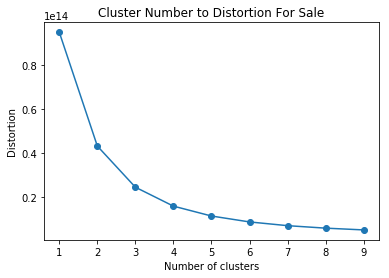

In [24]:
for_sale_res = run_k_mean(df_for_sale, 10, 'Cluster Number to Distortion For Sale')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


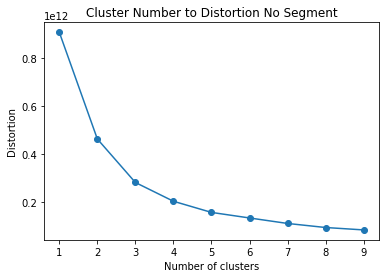

In [25]:
no_segment_res = run_k_mean(df_no_segment, 10, 'Cluster Number to Distortion No Segment')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


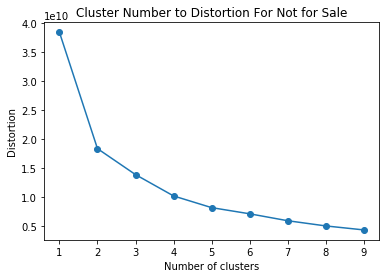

In [26]:
not_for_sale_res = run_k_mean(df_not_for_sale, 10, 'Cluster Number to Distortion For Not for Sale')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


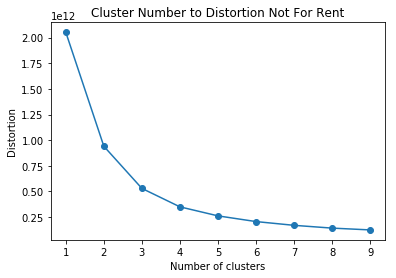

In [27]:
for_rent_res = run_k_mean(df_for_rent, 10, 'Cluster Number to Distortion Not For Rent')

In [32]:
normalized_for_sale_res_distortion = [i/max(for_sale_res[2]) for i in for_sale_res[2]]
print(normalized_for_sale_res_distortion)

[1.0, 0.4565178031444121, 0.2599981918570679, 0.16960209724732828, 0.12240992733066863, 0.09415225918090907, 0.07632593569867023, 0.06449213162100328, 0.05602893455756146]


In [33]:
normalized_no_segment_res_distortion = [i/max(no_segment_res[2]) for i in no_segment_res[2]]
print(normalized_no_segment_res_distortion)

[1.0, 0.5087877920802788, 0.3085128102575359, 0.22217327610038717, 0.1708143640874842, 0.14523917745252427, 0.11996778670705852, 0.10131391404439369, 0.0902505465513443]


In [35]:
normalized_not_for_sale_res_distortion = [i/max(not_for_sale_res[2]) for i in not_for_sale_res[2]]
print(normalized_not_for_sale_res_distortion)

[1.0, 0.47751452540823536, 0.36085189696143916, 0.26507042735620245, 0.21259131198264752, 0.1848677338834974, 0.1537759950970079, 0.1304308236683328, 0.1125120784594857]


In [36]:
normalized_for_rent_res_distortion = [i/max(for_rent_res[2]) for i in for_rent_res[2]]
print(normalized_for_rent_res_distortion)

[1.0, 0.4583800401013846, 0.25809354723241523, 0.1704468894670255, 0.12757661817070842, 0.10048874416143473, 0.08264644448700052, 0.06944250024960531, 0.06086140984315198]


## **Performance Summary of the Number of Clusters**

| Number of Clusters | For Sale Normalized Distortion | No Segment Normalized Distortion | Not For Sale Normalized Distortion | For Rent Normalized Distortion |
|------|------|------|------|------|
| 1  | 1 | 1 | 1 | 1 |
| 2  | 0.45 | 0.50  | 0.47 | 0.45  |
| 3  | 0.25 | 0.30  | 0.36 | 0.25 |
| 4  | 0.16 | 0.22 |  0.26 | 0.17 |
| 5  | 0.12 | 0.17 |  0.21 | 0.12 |
||||||
| **6**  | **0.09** | **0.14** |  **0.18** | **0.10** |
||||||
| 7  | 0.07 | 0.11 |  0.15 | 0.08 |
| 8  | 0.06 | 0.10 |  0.13 | 0.069 |
| 9  | 0.05 | 0.09 |  0.11 | 0.60 |

## Conclusions:
6 Clusters is a good number